In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jenkspy
import os

In [39]:
# parsing
def parse_latency_and_time(filename):
    curr = open(filename, "r")
    mode = ""
    latencies = []
    times = []
    start = float(curr.readline().split(":")[1][:-2])
    data = curr.read().split("\n\n")
    curr.close()
    for line in data:
        for itm in line.split("\n"):
            if not itm:
                continue
            msg, val = itm.split(":")
            if msg == "LATENCY":
                latencies.append(float(val))
            elif msg == "TIMESTAMP":
                times.append(float(val)-float(start))
    
    return latencies, times


    



In [54]:
h264_latency, h264_time = parse_latency_and_time("h264-100.txt")
compressed_latency, compressed_time = parse_latency_and_time("compressed-100.txt")
print(h264_latency[0], h264_latency[-1000])


1987392.388104357 1987448.979357904


In [49]:
def calculate_sigma(latencies, window=100):
        if len(latencies) <= 100:
            return
        return np.percentile(latencies[-100:], 68)
        
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])
    
    stat = 0
    
    separated_arrays = []
    
    for i in range(len(classes) - 1):
        idx = np.where(np.logical_and(array >= classes[i], array < classes[i+1]))
        separated_arrays.append(array[idx])

    for i in range(len(separated_arrays)-1, -1, -1):
        if len(separated_arrays[i]) / len(array) > 0.05:
            stat = np.mean(separated_arrays[i])
            break
        

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf, classes

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

def calculate_jitter(latencies):
    jitter = np.diff(latencies)
    avg_jitter = np.mean(np.abs(jitter))
    return avg_jitter

def plot_latency(latencies):
    # Ensure latencies are sorted for percentile calculations
    sorted_latencies = np.sort(latencies)

    # Calculate metrics
    mean = np.mean(latencies)
    median = np.median(latencies)
    std = np.std(latencies)
    p95 = np.percentile(sorted_latencies, 95)
    p99 = np.percentile(sorted_latencies, 99)
    min_latency = np.min(latencies)
    max_latency = np.max(latencies)
    
    # print("mean 85%+", np.mean(sorted_latencies[np.where(sorted_latencies >= np.percentile(sorted_latencies,85))]))
    
    gvf = 0.0
    for nclasses in [2, 3, 4, 5]:
        gvf, classes = goodness_of_variance_fit(np.array(latencies), nclasses)
        if gvf > 0.9:
            break
        # print('gvf:', gvf)
        # print('ncl', nclasses)
        
    # Plot the raw latencies
    plt.hist(sorted_latencies, bins=40)
    
    # for d in classes:
    #     plt.axvline(x=d, color='r')
    
    # Plot metrics
    # plt.axhline(y=mean, color='r', linestyle='-', label=f'Mean: {mean:.2f},' + f'StD: {std:.2f}')
    # plt.axhline(y=median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    # plt.axhline(y=p95, color='y', linestyle='-', label=f'95th percentile: {p95:.2f}')
    # plt.axhline(y=p99, color='m', linestyle='-', label=f'99th percentile: {p99:.2f}')
    # plt.axhline(y=min_latency, color='c', linestyle='-', label=f'Min: {min_latency:.2f}')
    # plt.axhline(y=max_latency, color='b', linestyle='-', label=f'Max: {max_latency:.2f}')

    # Setting labels and legend
    plt.title("Latency Distribution")
    plt.xlabel("Latency")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
        
def plot_latency_over_time(timestamps, latencies):
    # Ensure latencies are sorted based on timestamps
    sorted_indices = np.argsort(timestamps)
    sorted_latencies = np.array(latencies)[sorted_indices]
    sorted_timestamps = np.array(timestamps)[sorted_indices]
    
    # Calculate metrics
    mean = np.mean(sorted_latencies)
    median = np.median(sorted_latencies)
    std = np.std(latencies)
    p95 = np.percentile(sorted_latencies, 95)
    p99 = np.percentile(sorted_latencies, 99)
    min_latency = np.min(sorted_latencies)
    max_latency = np.max(sorted_latencies)

    # Plot the raw latencies over time
    plt.plot(sorted_timestamps, sorted_latencies, color='blue', label="Latencies", linestyle='-')

    # Plot metrics
    plt.axhline(y=mean, color='r', linestyle='-', label=f'Mean: {mean:.2f},' + f'StD: {std:.2f}')
    plt.axhline(y=median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    plt.axhline(y=p95, color='y', linestyle='-', label=f'95th percentile: {p95:.2f}')
    plt.axhline(y=p99, color='m', linestyle='-', label=f'99th percentile: {p99:.2f}')
    plt.axhline(y=min_latency, color='c', linestyle='-', label=f'Min: {min_latency:.2f}')
    plt.axhline(y=max_latency, color='b', linestyle='-', label=f'Max: {max_latency:.2f}')

    # Setting labels, legend, and formatting
    plt.title("Latency Distribution Over Time")
    plt.xlabel("Time")
    plt.ylabel("Latency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


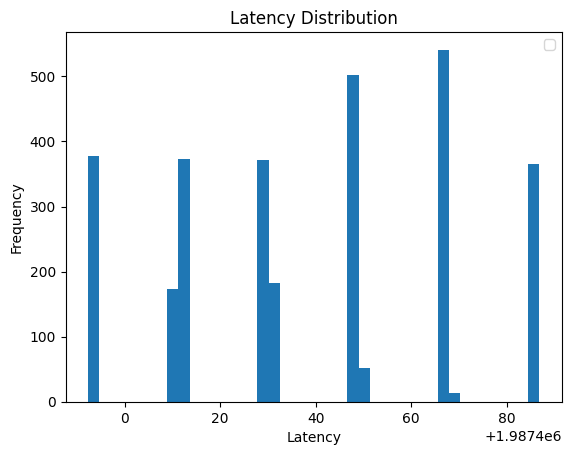

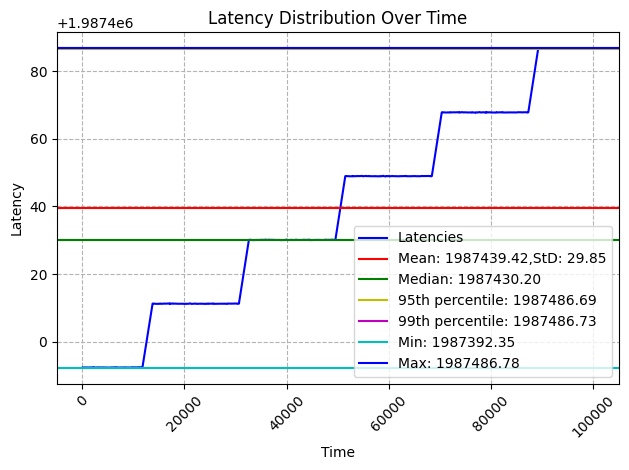

In [50]:
plot_latency(np.array(h264_latency))
plot_latency_over_time(h264_time, h264_latency)